(content:vad)=
# Voice Activity Detection (VAD)

## Introduction
![vadspp](code/vad_spp-1.png)

-   *Voice activity detection* (VAD) (or speech activity detection, or
    speech detection) refers to a class of methods which detect whether
    a sound signal contains speech or not.
-   A closely related and partly overlapping task is *speech presence
    probability* (SPP) estimation.
    -   Instead of a binary present/not-present decision, SPP gives a
        probability level that the signal contains speech.
    -   A VAD can be derived from SPP by setting a threshold probability
        above which the signal is considered to contain speech.
    -   In most cases, SPP is thus the more fundamental problem.
-   Voice activity detection is used as a pre-processing algorithm for
    almost all other speech processing methods.
    -   In *speech coding*, it is used to to determine when speech
        transmission can be switched off to reduce the amount of
        transmitted data.
    -   In *speech recognition*, it is used to find out what parts of
        the signal should be fed to the recognition engine. Since
        recognition is a computationally complex operation, ignoring
        non-speech parts saves CPU power.
-   VAD or SPP is thus used mostly as a resource-saving operation.
-   In *speech enhancement*, where we want to reduce or remove noise in
    a speech signal, we can estimate noise characteristics from
    non-speech parts (learn/adapt) and remove noise from the speech
    parts (apply).
-   A closely related method in *audio* applications is *noise gateing*,
    where typically a microphone signal is muted whenever there is no
    signal present.
    -   For example, when a singer is not singing in the microphone,
        then the microphone is off. When the singer is not singing,
        microphone signal is only noise and therefore the noise gate
        removes (gates) noise.
-   VADs can thus also be used in improving signal quality.


## Low-noise VAD = Trivial case
![vadsad](code/vad_sad-1.png)

-   To introduce basic vocabulary and methodology, let us consider a
    case where a speaker is speaking in an (otherwise) silent
    environment. 
    -   When there is no speech, there is silence.
    -   (Any) Signal activity indicates voice activity.
-   Signal activity can be measured by, for example, estimating signal
    energy per frame $\Rightarrow$ the *energy thresholding algorithm*.

In [102]:
# Initialization for all
from scipy.io import wavfile
import numpy as np 
import matplotlib.pyplot as plt
import IPython.display as ipd 
import scipy 
import scipy.fft 

#from helper_functions import stft, istft, halfsinewindow

In [103]:
def stft(data,fs,window_length_ms=30,window_step_ms=20,windowing_function=None):
    window_length = int(window_length_ms*fs/2000)*2
    window_step = int(window_step_ms*fs/1000)
    if windowing_function is None:
        windowing_function = np.sin(np.pi*np.arange(0.5,window_length,1)/window_length)**2
    
    total_length = len(data)
    window_count = int( (total_length-window_length)/window_step) + 1
    
    spectrum_length = int((window_length)/2)+1
    spectrogram = np.zeros((window_count,spectrum_length),dtype=complex)

    for k in range(window_count):
        starting_position = k*window_step

        data_vector = data[starting_position:(starting_position+window_length),]
        window_spectrum = scipy.fft.rfft(data_vector*windowing_function,n=window_length)

        spectrogram[k,:] = window_spectrum
        
    return spectrogram

def istft(spectrogram,fs,window_length_ms=30,window_step_ms=20,windowing_function=None):
    window_length = int(window_length_ms*fs/2000)*2
    window_step = int(window_step_ms*fs/1000)
    #if windowing_function is None:
    #    windowing_function = np.ones(window_length)
    window_count = spectrogram.shape[0]
    
    total_length = (window_count-1)*window_step + window_length
    data = np.zeros(total_length)
    
    for k in range(window_count):
        starting_position = k*window_step
        ix = np.arange(starting_position,starting_position+window_length)

        thiswin = scipy.fft.irfft(spectrogram[k,:],n=window_length)
        data[ix] = data[ix] + thiswin*windowing_function
        
    return data


def halfsinewindow(window_length):
    return np.sin(np.pi*np.arange(0.5,window_length,1)/window_length)

In [104]:
fs = 16000  # Sample rate
seconds = 5  # Duration of recording
window_length_ms=30
window_step_ms=15
window_length = int(window_length_ms*fs/2000)*2
window_step_samples = int(window_step_ms*fs/1000)

windowing_function = halfsinewindow(window_length)

filename = 'sounds/vad_test1.wav'

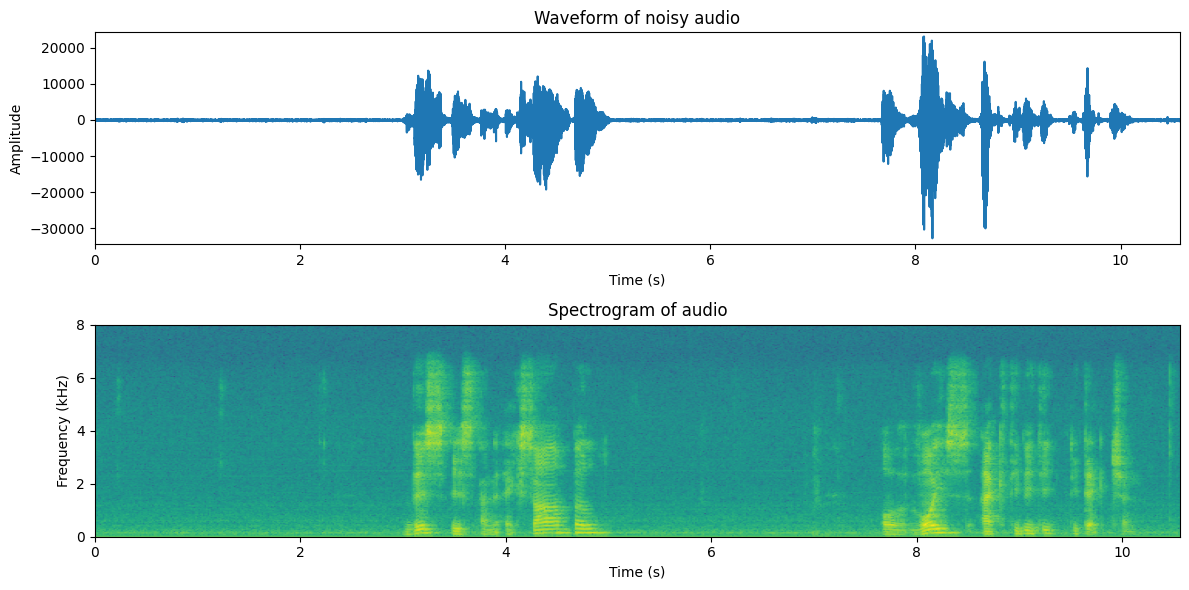

In [105]:
# read from storage
fs, data = wavfile.read(filename)
data = data[:]

ipd.display(ipd.Audio(data,rate=fs))

plt.figure(figsize=[12,6])
plt.subplot(211)
t = np.arange(0,len(data),1)/fs

plt.plot(t,data)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform of noisy audio')
plt.axis([0, len(data)/fs, 1.05*np.min(data), 1.05*np.max(data)])


spectrogram_matrix = stft(data,
                          fs,
                          window_length_ms=window_length_ms,
                          window_step_ms=window_step_ms,
                         windowing_function=windowing_function)
fft_length = spectrogram_matrix.shape[1]
window_count = spectrogram_matrix.shape[0]
length_in_s = window_count*window_step_ms/1000
plt.subplot(212)
plt.imshow(20*np.log10(np.abs(spectrogram_matrix[:,range(fft_length)].T)),
           origin='lower',aspect='auto',
           extent=[0, length_in_s, 0, fs/2000])
plt.axis([0, length_in_s, 0, 8])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)');
plt.title('Spectrogram of audio')
plt.tight_layout()
plt.show()

In [106]:
frame_energy = np.sum(np.abs(spectrogram_matrix)**2,axis=1)
frame_energy_dB = 10*np.log10(frame_energy)
mean_energy_dB = np.mean(frame_energy_dB) # mean of energy in dB

threshold_dB = mean_energy_dB - 3. # threshold relative to mean

speech_active = frame_energy_dB > threshold_dB

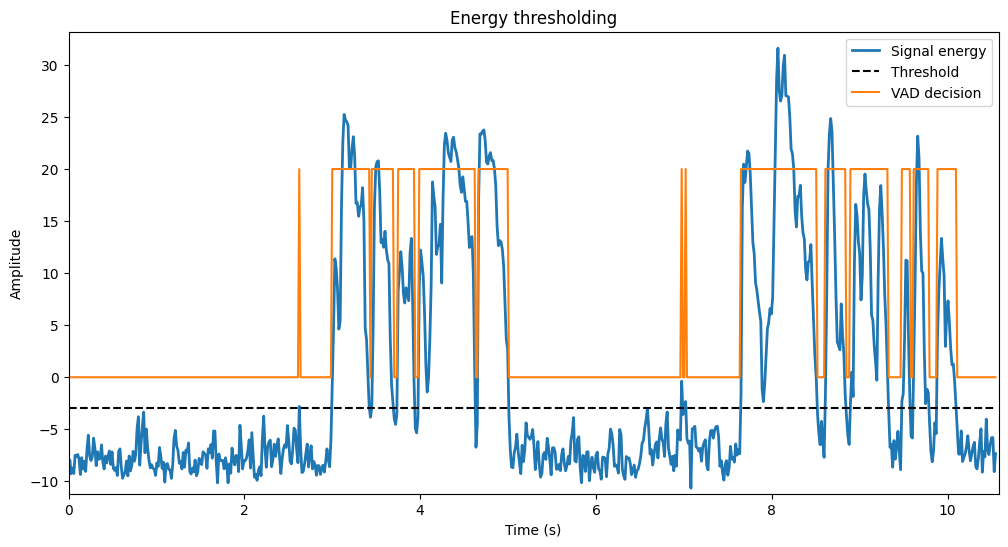

In [107]:
# Illustrate thresholding (without hysteresis)
plt.figure(figsize=[12,6])
#plt.subplot(211)

t = np.arange(0,window_count,1)*window_step_samples/fs
normalized_frame_energy = frame_energy_dB - np.mean(frame_energy_dB)
plt.plot(t,normalized_frame_energy,linewidth=2,label='Signal energy')
plt.plot(t,threshold_dB + t*0 - np.mean(frame_energy_dB), 'k--', label='Threshold')
plt.plot(t,speech_active*20,label='VAD decision')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Energy thresholding')
plt.axis([0, len(data)/fs, 1.05*np.min(normalized_frame_energy), 1.05*np.max(normalized_frame_energy)])

plt.show()

-   Clearly energy thresholding works for silent speech signals.
    -   Low-energy frames are correctly labeled as non-speech and speech
        parts are likewise correctly labeled.
-   It is however not trivial to choose an appropriate threshold-level.
    -   A low threshold level would make sure that all speech-frames are
        correctly labeled. However, we might then also label frames with
        other sounds, like breathing sounds or other background noises,
        as speech frames.
    -   A high threshold would make sure that all detected speech-frames
        actually are truly speech frames. But then we could miss offsets
        (sounds which are trailing off), since they often have a low
        energy.
-   What strategy should we use to choose a threshold?
    -   What is the correct label for something like breathing-noises?
    -   How do we actually measure performance of a VAD?

## VAD objective and performance measurement

-   The objective of a VAD implementation depends heavily on the
    application.
    -   In speech coding, our actual objective is to reduce bitrate
        without decreasing quality. $\Rightarrow$ We want to make sure
        that no speech frames are classified as background noise,
        because that would reduce quality. 
        
        $\Rightarrow$ We make a conservative estimate.
        
    -   In keyword spotting (think "Siri" or "OK Google"), we want to
        detect the start of a particular combination of words. The VADs
        task is to avoid running a computationally expensive keyword
        spotting algorithm all the time. Missing one keyword is not so
        bad (the user would then just try again), but if it is too
        sensitive then the application would drain the battery.
        
        $\Rightarrow$ We want to be sure that only keywords are spotted.

-   The objective of a VAD implementation depends heavily on the
    application.
    -   In speech enhancement, we want to find non-speech areas such
        that we can there estimate noise characteristics, such that we
        can remove anything which looks like noise. We want to be sure
        that there is no speech in the noise estimate, otherwise we
        would end up removing some speech and not only noise.
    -   In speech recognition, VAD is used purely for resource saving.
        We do not want to reduce accuracy of the recognition, but want
        to minimize CPU usage.
-   We need a set of performance measures which reflect these different
    objectives.
-   The performance is then often described by looking at how often are
    frames which do contain speech labeled as speech/non-speech, and how
    often is non-speech labeled as speech/non-speech?

| Input        | Speech           | Non-speech |
| --- | --- | --- |
| Speech       | True positive    | False negative |
| Non-speech   | False positive   | True negative |

-   For speech coding, we want to keep the number of false negatives low, and false positives are of only secondary importance.
-   For keyword spotting, we want to keep the number of false positives low, and false negatives are secondary importance.

### Performance in noise

- The case of speech without background noise is trivial and unrealistic.
- Usually, we speak in environments with background noise.
- Setting the energy threshold is a complex process.
  
Below is an example with SNR=0dB, where a 1dB change in the threshold has a large impact.

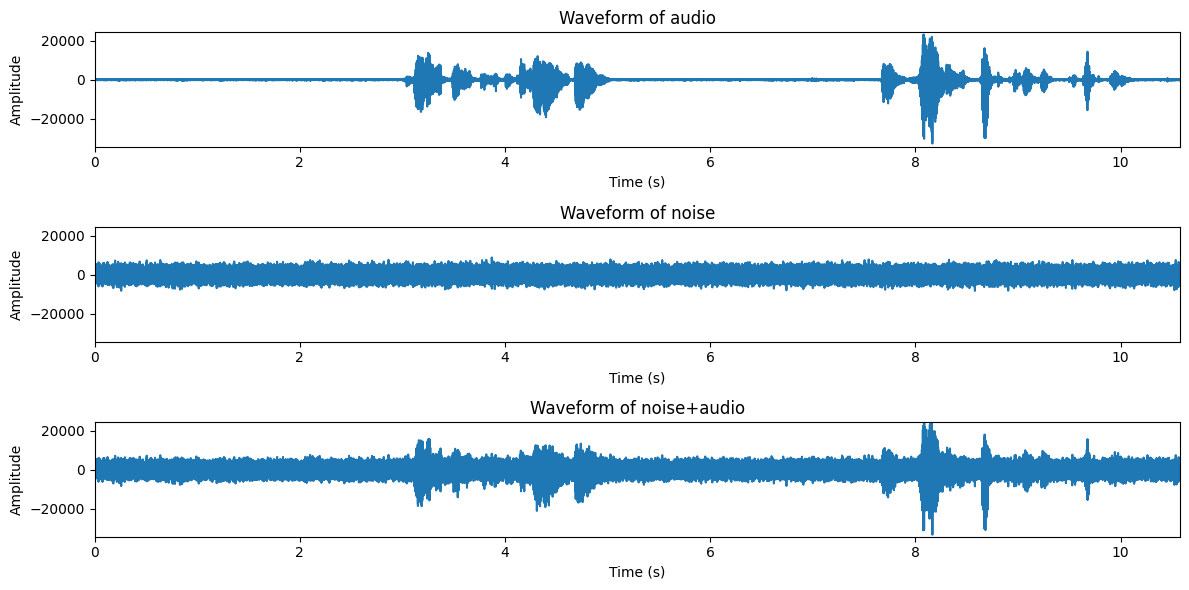

In [108]:
# read from storage
noise = np.random.randn(data.shape[0])*np.std(data)

plt.figure(figsize=[12,6])
plt.subplot(311)
t = np.arange(0,len(data),1)/fs

plt.plot(t,data)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform of audio')
plt.axis([0, len(data)/fs, 1.05*np.min(data), 1.05*np.max(data)])

plt.subplot(312)
t = np.arange(0,len(data),1)/fs

plt.plot(t,noise)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform of noise')
plt.axis([0, len(data)/fs, 1.05*np.min(data), 1.05*np.max(data)])

plt.subplot(313)
t = np.arange(0,len(data),1)/fs

plt.plot(t,data+noise)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform of noise+audio')
plt.axis([0, len(data)/fs, 1.05*np.min(data), 1.05*np.max(data)])
plt.tight_layout()

ipd.display(ipd.Audio(data,rate=fs))
ipd.display(ipd.Audio(noise,rate=fs))
ipd.display(ipd.Audio(data+noise,rate=fs))


noise_spectrogram_matrix = stft(noise,
                          fs,
                          window_length_ms=window_length_ms,
                          window_step_ms=window_step_ms,
                         windowing_function=windowing_function)

In [109]:
noisy_frame_energy = np.sum(np.abs(spectrogram_matrix+noise_spectrogram_matrix)**2,axis=1)
noisy_frame_energy_dB = 10*np.log10(noisy_frame_energy)
noisy_mean_energy_dB = np.mean(noisy_frame_energy_dB) # mean of energy in dB

noisy_threshold_dB = noisy_mean_energy_dB  # threshold relative to mean

noisy_speech_active = noisy_frame_energy_dB > noisy_threshold_dB

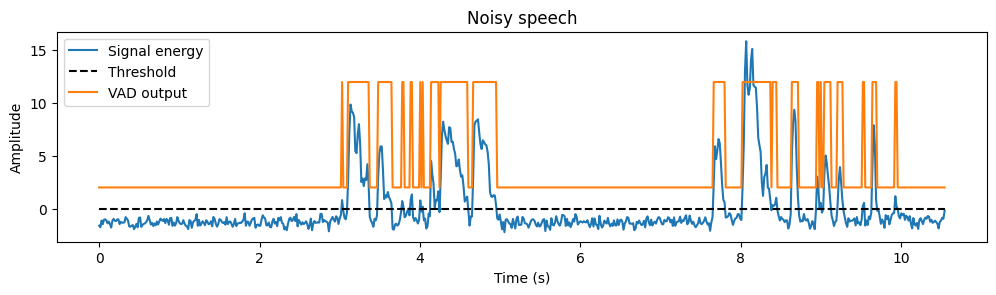

In [110]:
# Illustrate thresholding 
plt.figure(figsize=[12,6])
plt.subplot(211)

normalized_noisy_frame_energy = noisy_frame_energy_dB - noisy_mean_energy_dB

t = np.arange(0,window_count,1)*window_step_samples/fs
plt.plot(t,normalized_noisy_frame_energy,label='Signal energy')
plt.plot(t,noisy_threshold_dB + t*0 - noisy_mean_energy_dB, 'k--', label='Threshold')
plt.plot(t,noisy_speech_active*10+2,label='VAD output')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Noisy speech')
#plt.axis([0, len(data)/fs, 1.05*np.min(normalized_frame_energy), 1.05*np.max(normalized_frame_energy)])
plt.show()

# Reconstruct and play thresholded signal
spectrogram_hysteresis = (spectrogram_matrix+noise_spectrogram_matrix) * np.expand_dims(noisy_speech_active,axis=1)
data_hysteresis = istft(spectrogram_hysteresis,fs,window_length_ms=window_length_ms,window_step_ms=window_step_ms,windowing_function=windowing_function)
ipd.display(ipd.Audio(data_hysteresis,rate=fs))

In [111]:
noisy_threshold_dB = noisy_mean_energy_dB -1  # threshold relative to mean

noisy_speech_active = noisy_frame_energy_dB > noisy_threshold_dB

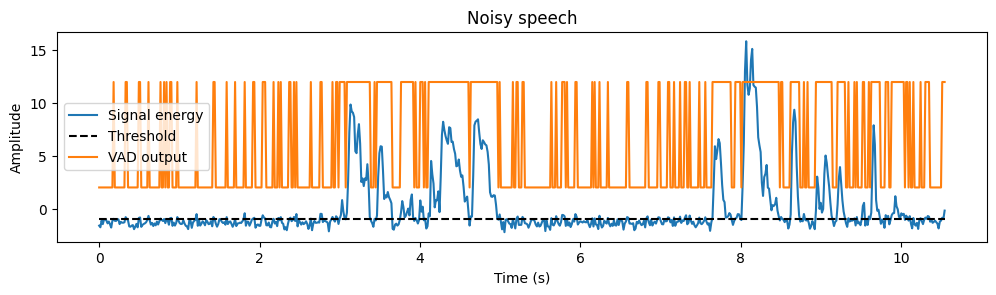

In [112]:
# Illustrate thresholding 
plt.figure(figsize=[12,6])
plt.subplot(211)

normalized_noisy_frame_energy = noisy_frame_energy_dB - noisy_mean_energy_dB

t = np.arange(0,window_count,1)*window_step_samples/fs
plt.plot(t,normalized_noisy_frame_energy,label='Signal energy')
plt.plot(t,noisy_threshold_dB + t*0 - noisy_mean_energy_dB, 'k--', label='Threshold')
plt.plot(t,noisy_speech_active*10+2,label='VAD output')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Noisy speech')
#plt.axis([0, len(data)/fs, 1.05*np.min(normalized_frame_energy), 1.05*np.max(normalized_frame_energy)])
plt.show()

# Reconstruct and play thresholded signal
spectrogram_hysteresis = (spectrogram_matrix+noise_spectrogram_matrix) * np.expand_dims(noisy_speech_active,axis=1)
data_hysteresis = istft(spectrogram_hysteresis,fs,window_length_ms=window_length_ms,window_step_ms=window_step_ms,windowing_function=windowing_function)
ipd.display(ipd.Audio(data_hysteresis,rate=fs))

## Post-processing

-   We already saw that speech coding wants to avoid false negatives
    (=speech frames labeled as non-speech).
-   Can we identify typical situations where false negatives occur?
    -   Offsets (where a phonation ends) often have low energy\
        $\Rightarrow$ Easily misclassified as non-speech.
    -   Stops have a silence in the middle of an utterance.\
        $\Rightarrow$ Easily misclassified as non-speech.
-   We should be careful at the end of phonations.
    -   We can use a *hangover* time, such that after a speech segment
        we keep the label as speech for a while until we are sure that
        speech has ended.
    -   For onsets (starts of phonemes) we usually want to be very
        sensitive.
-   We obtain a hysteresis rule;
    -   If any of the last $K$ frames was identified as speech, then the

        current frame is labelled as speech. Otherwise non-speech.

In [113]:
hysteresis_time_ms = 180
hysteresis_time = int(hysteresis_time_ms/window_step_ms)

speech_active_hysteresis = np.zeros([window_count])
for window_ix in range(window_count):
    range_start = max(0,window_ix-hysteresis_time)
    speech_active_hysteresis[window_ix] = np.max(speech_active[range(range_start,window_ix+1)])

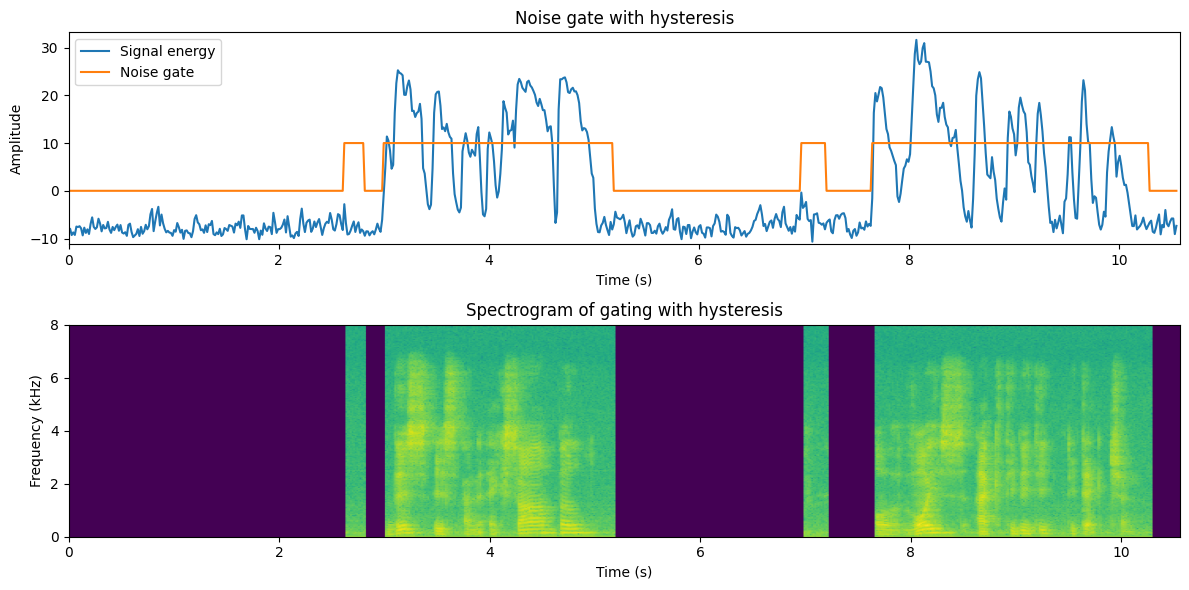

In [114]:
# Reconstruct and play thresholded signal
spectrogram_hysteresis = spectrogram_matrix * np.expand_dims(speech_active_hysteresis,axis=1)
data_hysteresis = istft(spectrogram_hysteresis,fs,window_length_ms=window_length_ms,window_step_ms=window_step_ms,windowing_function=windowing_function)

# Illustrate thresholding (without hysteresis)
plt.figure(figsize=[12,6])
plt.subplot(211)

t = np.arange(0,window_count,1)*window_step_samples/fs
normalized_frame_energy = frame_energy_dB - np.mean(frame_energy_dB)
plt.plot(t,normalized_frame_energy,label='Signal energy')
plt.plot(t,speech_active_hysteresis*10,label='Noise gate')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Noise gate with hysteresis')
plt.axis([0, len(data)/fs, 1.05*np.min(normalized_frame_energy), 1.05*np.max(normalized_frame_energy)])


plt.subplot(212)

plt.imshow(20*np.log10(1e-6+np.abs(spectrogram_hysteresis[:,range(fft_length)].T)),
           origin='lower',aspect='auto',
           extent=[0, length_in_s, 0, fs/2000])
plt.axis([0, length_in_s, 0, 8])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)');
plt.title('Spectrogram of gating with hysteresis')
plt.tight_layout()
plt.show()

ipd.display(ipd.Audio(data_hysteresis,rate=fs))



## VAD for noisy speech

-   Clean speech (absolutely no background noise) is very rare, if not
    impossible to achieve.
-   Real-life speech recordings practically always have varying amounts
    of background noise.
    -   The performance of energy thresholding decreases rapidly when the
        SNR drops.
    -   For example, weak offsets easily disappear in noise.
-   We need more advanced VAD methods for noisy speech.
    -   We need to identify characteristics that differentiate between
        speech and noise.
    -   Measures for such characteristics are known as *features*.

### Features
![vadfeat](code/vad_features1-1.png)

-   In VAD, with features we try to measure some property of the signal
    which would give an indication to whether the signal is speech or
    non-speech.
    -   Signal energy is naturally a useful feature, since the energy of
        speech varies a lot.
    -   Voiced sounds generally have energy mainly at the low
        frequencies, whereby estimators for spectral tilt are often
        useful. For example,
        -   Zero-crossings (per time unit) is high for high-frequency
            signals (noise) and low for low-frequency signals (voiced
            speech), whereby it can be used as a feature.
        -   The lag-1 autocorrelation is high (close to one) for
            low-frequency signals and low (close to -1) for
            high-frequency signals.
-   Speech sounds can be efficiently modelled by linear prediction.
    -   If the prediction error is small, then it is likely that the
        signal is speech.
    -   If the prediction error is large, then it is probably
        non-speech.
-   Voiced speech has by definition a prominent pitch.
    -   If we can identify a prominent pitch in the range then it is
        likely voiced speech.
-   Speech information is described effectively by their spectral
    envelope.
    -   MFCC can be used as a description of envelope information and it
        is thus a useful set of features.
    -   Linear prediction parameters (esp. prediction residual) also
        describe envelope information and can thus also be used as a
        feature-set.
![vadfeat2](code/vad_features2-1.png)
        
-   Speech features vary rapidly and frequently.
    -   By looking at the rate of change $\Delta_k=f_{k+1}-f_k$ in other
        features $f_k$, we obtain information about the rate of change
        of the signal. (Estimate of derivative)
    -   Likewise, we can look at the second difference
        $\Delta\Delta_k=\Delta_{k+1}-\Delta_k$. (Estimate of second
        derivative)
    -   These first and second order differences can be used as features
        and they are known as $\Delta$- and $\Delta\Delta$-features.


## Classifier


-   We have collected a set of indicators for speech, the features,
    whereby the next step is to merge the information from these
    features to make a decision between speech and non-speech.
-   Classification is generic problem, with plenty of solutions such as
    -   decision trees (low-complexity, requires manual tuning)
    -   linear classifier (relatively low-complexity, training from
        data)
    -   deep neural networks (high-complexity, high-accuracy, training from data)
![vad2](code/vad2-1.png)

The following examples use deep neural networks from [SpeechBrain](https://speechbrain.readthedocs.io/en/latest/tutorials/tasks/voice-activity-detection.html).

In [151]:
from speechbrain.inference.VAD import VAD

file1 = "sounds/vad_test1.wav"

VAD = VAD.from_hparams(source="speechbrain/vad-crdnn-libriparty", savedir="pretrained_models/vad-crdnn-libriparty")
boundaries = VAD.get_speech_segments(file1)
VAD.save_boundaries(boundaries)

prob_chunks = VAD.get_speech_prob_file(file1)

segment_001  0.00  2.70 NON_SPEECH
segment_002  2.70  5.88 SPEECH
segment_003  5.88  7.40 NON_SPEECH
segment_004  7.40  10.55 SPEECH


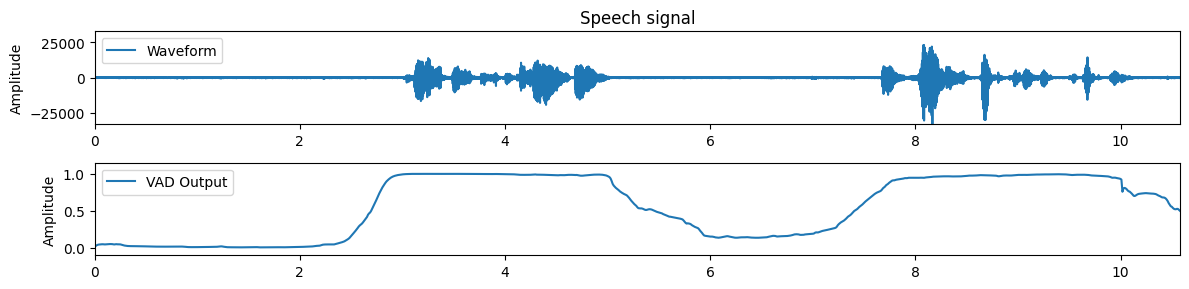

In [150]:
plt.figure(figsize=(12,3))
fs, data = wavfile.read(file1)
data = data[:]
t = np.arange(0,len(data),1)/fs

plt.subplot(211)
plt.plot(t,data,label='Waveform')
plt.ylabel('Amplitude')
plt.title('Speech signal')
plt.axis([0, len(data)/fs, -1.05*np.max(np.abs(data)), 1.05*np.max(np.abs(data))])
plt.legend()


plt.subplot(212)
t = np.linspace(0,1,num=prob_chunks.squeeze().shape[0])*len(data)/fs
plt.plot(t,prob_chunks.squeeze(),label='VAD Output')
plt.ylabel('Amplitude')
plt.axis([0, len(data)/fs, -.1, 1.15])
plt.legend()

plt.tight_layout()
plt.show()

ipd.display(ipd.Audio(data,rate=fs))

In [ ]:
file2 = "sounds/vad_test2.wav"

VAD = VAD.from_hparams(source="speechbrain/vad-crdnn-libriparty", savedir="pretrained_models/vad-crdnn-libriparty")
boundaries = VAD.get_speech_segments(file2)
VAD.save_boundaries(boundaries)

prob_chunks = VAD.get_speech_prob_file(file2)

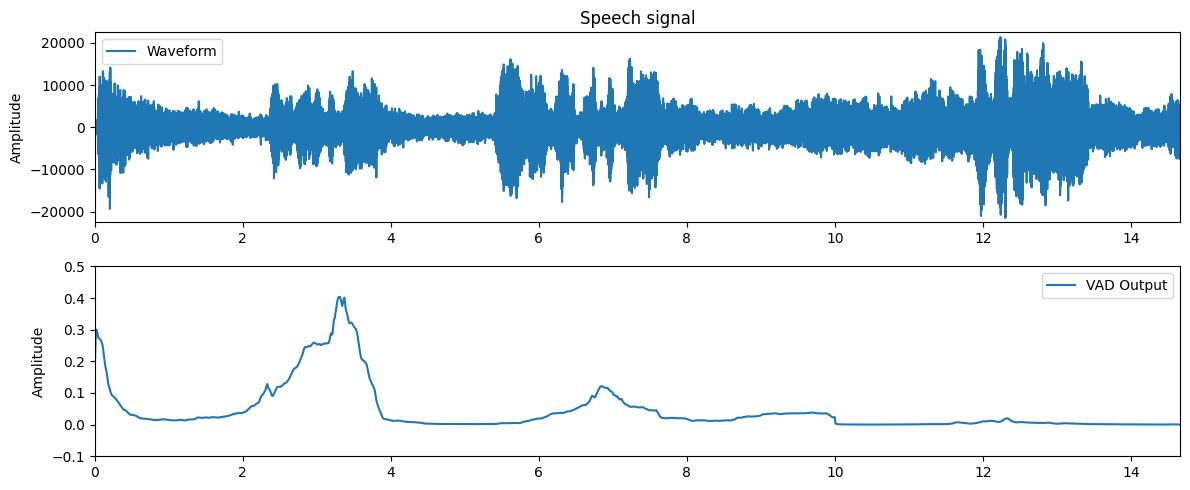

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(211)
fs, data = wavfile.read(file2)
data = data[:]
t = np.arange(0,len(data),1)/fs

plt.plot(t,data,label='Waveform')
plt.ylabel('Amplitude')
plt.title('Speech signal')
plt.axis([0, len(data)/fs, -1.05*np.max(np.abs(data)), 1.05*np.max(np.abs(data))])
plt.legend()


plt.subplot(212)
t = np.linspace(0,1,num=prob_chunks.squeeze().shape[0])*len(data)/fs
plt.plot(t,prob_chunks.squeeze(),label='VAD Output')
plt.ylabel('Amplitude')
plt.axis([0, len(data)/fs, -.1, .5])
plt.legend()

plt.tight_layout()
plt.show()


ipd.display(ipd.Audio(data,rate=fs))

The two above examples demonstrate that VAD in noise is a difficult problem.

## Speech Presence Probability

-   The output of the classifier is a continuous number, but it is
    thresholded to obtain a decision.
-   The continuous output contains a lot of information about the signal
    which is lost when applying thresholding.
    -   With a high value we are really certain that the signal is
        speech, while a value near the threshold is relatively
        uncertain.
-   We can use the classifier output as an estimate of the probability
    that the signal is speech $\Rightarrow$ It is an estimator for
    *speech presence probability*.
-   Subsequent applications can use this information as input to improve
    performance.
    
![vadspp](code/vad_spp-1.png)



### Output before thresholding
![vadfeat5](code/vad_features5-1.png)


## Noise types
-   As noted before, VAD is trivial in noise-free scenarios.
-   In practice, typical background noise types are for example, office
    noise, car noise, cafeteria (babble) noise, street noise, factory
    noise, ...
-   Clearly the problem is easier if the noise has a very different
    character than the speech signal.
    -   Speech is quickly varying $\Rightarrow$ stationary noises are
        easy.
    -   Speech is dominated by low frequencies $\Rightarrow$ high
        frequency noises are easy.
-   The classic worst case is a competing (undesired) speaker, when
    someone else is speaking in the background (babble noise).
    -   However, that would be difficult also for a human listener,
        whereby it actually is a very difficult problem.


## Conclusions

-   Voice activity detection is a type of methods which attempt to
    determine if a signal is speech or non-speech.
    -   In a noise-free scenario the task is trivial, but it is also not
        a realistic scenario.
-   The basic idea of algorithms is:
    1.  Calculate a set of features from the signal which are designed
        to analyze properties which differentiate speech and non-speech.
    2.  Merge the information from the features in a classifier, which
        returns the likelihood that the signal is speech.
    3.  Threshold the classifier output to determine whether the signal
        is speech or not.
-   VADs are used as a low-complexity pre-processing method, to save
    resources (e.g. complexity or bitrate) in the main task.


## See also

The [SpeechBrain](https://speechbrain.readthedocs.io/en/latest/tutorials/tasks/voice-activity-detection.html) project has a nice introduction to VAD.
    